In [31]:
import torch
import numpy as np
import random
import os

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed) 
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    os.environ['PYTHONHASHSEED'] = str(seed)
    
    print(f"Seed set to: {seed} (Reproducibilidad activada)")

set_seed(42)

Seed set to: 42 (Reproducibilidad activada)


In [32]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split

X = pd.read_csv('data/data.csv', index_col=0)
y = pd.read_csv('data/labels.csv', index_col=0)

X_log =np.log2(X + 1)

top_genes = X_log.var().sort_values(ascending=False).head(5000).index
X_filtered = X_log[top_genes]

scaler = StandardScaler()
X_scaled= scaler.fit_transform(X_filtered)

le = LabelEncoder()
y_encoded = le.fit_transform(y['Class'])

X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_encoded, test_size=0.2, random_state=42)

print(f"Data ready. Type of training: {X_train.shape}")
print(f"Classes detected: {le.classes_}")

Data ready. Type of training: (640, 5000)
Classes detected: ['BRCA' 'COAD' 'KIRC' 'LUAD' 'PRAD']


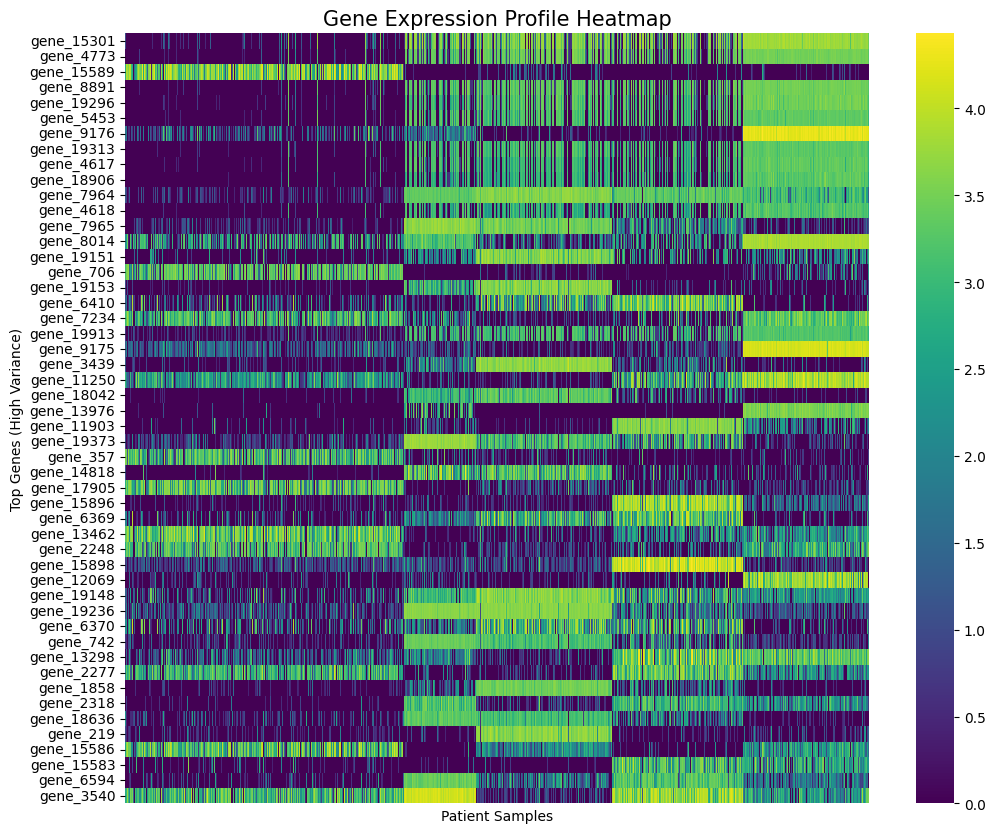

In [33]:
import seaborn as sns
import matplotlib.pyplot as plt

top_genes_indices = X_log.var().sort_values(ascending=False).head(50).index
df_heatmap = X_log[top_genes_indices].copy()

df_heatmap['Cancer_Type'] = y 

df_heatmap = df_heatmap.sort_values(by='Cancer_Type')

plt.figure(figsize=(12, 10))
sns.heatmap(df_heatmap.drop('Cancer_Type', axis=1).T, 
            cmap='viridis', 
            xticklabels=False, 
            yticklabels=True)

plt.title("Gene Expression Profile Heatmap", fontsize=15)
plt.xlabel("Patient Samples")
plt.ylabel("Top Genes (High Variance)")
plt.show()

In [34]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

train_loader = DataLoader(TensorDataset(torch.FloatTensor(X_train), torch.LongTensor(y_train)),batch_size=32, shuffle=True)
test_loader = DataLoader(TensorDataset(torch.FloatTensor(X_test), torch.LongTensor(y_test)), batch_size=32)

class DeepOncoClass(nn.Module):
    def __init__(self, input_dim, num_classes):
        super().__init__()
        self.encoder = nn.Sequential(
            nn.Linear(input_dim, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, 128), 
            nn.ReLU()
        )
        self.latent = nn.Linear(128,64)
        self.classifier = nn.Sequential(
            nn.Linear(64,32),
            nn.ReLU(),
            nn.Linear(32, num_classes)
        )
    def forward(self, x):
        x = self.encoder(x)
        z= self.latent(x)
        logits = self.classifier(z)
        return logits, z
model = DeepOncoClass(input_dim=5000, num_classes=len(le.classes_))
print(model)

DeepOncoClass(
  (encoder): Sequential(
    (0): Linear(in_features=5000, out_features=512, bias=True)
    (1): ReLU()
    (2): Dropout(p=0.3, inplace=False)
    (3): Linear(in_features=512, out_features=128, bias=True)
    (4): ReLU()
  )
  (latent): Linear(in_features=128, out_features=64, bias=True)
  (classifier): Sequential(
    (0): Linear(in_features=64, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=5, bias=True)
  )
)


In [35]:
import torch

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

history = {
    'train_loss': [],
    'val_loss': [],
    'train_acc': [],
    'val_acc': []
}

epochs = 15
for epoch in range(epochs):
    model.train()
    train_loss = 0
    correct_train = 0
    total_train = 0
    
    for batch_x, batch_y in train_loader:
        optimizer.zero_grad()
        outputs, _ = model(batch_x)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total_train += batch_y.size(0)
        correct_train += (predicted == batch_y).sum().item()
    
    model.eval()
    val_loss = 0
    correct_val = 0
    total_val = 0
    
    with torch.no_grad():
        for batch_x, batch_y in test_loader: 
            outputs, _ = model(batch_x)
            loss = criterion(outputs, batch_y)
            val_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total_val += batch_y.size(0)
            correct_val += (predicted == batch_y).sum().item()

    history['train_loss'].append(train_loss / len(train_loader))
    history['val_loss'].append(val_loss / len(test_loader))
    history['train_acc'].append(100 * correct_train / total_train)
    history['val_acc'].append(100 * correct_val / total_val)
    
    print(f"Epoch {epoch+1}/{epochs} | Train Loss: {history['train_loss'][-1]:.4f} | Val Acc: {history['val_acc'][-1]:.2f}%")

print("Training finished")

Epoch 1/15 | Train Loss: 0.3092 | Val Acc: 100.00%
Epoch 2/15 | Train Loss: 0.0041 | Val Acc: 100.00%
Epoch 3/15 | Train Loss: 0.0002 | Val Acc: 100.00%
Epoch 4/15 | Train Loss: 0.0000 | Val Acc: 100.00%
Epoch 5/15 | Train Loss: 0.0000 | Val Acc: 100.00%
Epoch 6/15 | Train Loss: 0.0000 | Val Acc: 100.00%
Epoch 7/15 | Train Loss: 0.0000 | Val Acc: 100.00%
Epoch 8/15 | Train Loss: 0.0000 | Val Acc: 100.00%
Epoch 9/15 | Train Loss: 0.0000 | Val Acc: 100.00%
Epoch 10/15 | Train Loss: 0.0000 | Val Acc: 100.00%
Epoch 11/15 | Train Loss: 0.0000 | Val Acc: 100.00%
Epoch 12/15 | Train Loss: 0.0000 | Val Acc: 100.00%
Epoch 13/15 | Train Loss: 0.0000 | Val Acc: 100.00%
Epoch 14/15 | Train Loss: 0.0000 | Val Acc: 100.00%
Epoch 15/15 | Train Loss: 0.0000 | Val Acc: 100.00%
Training finished


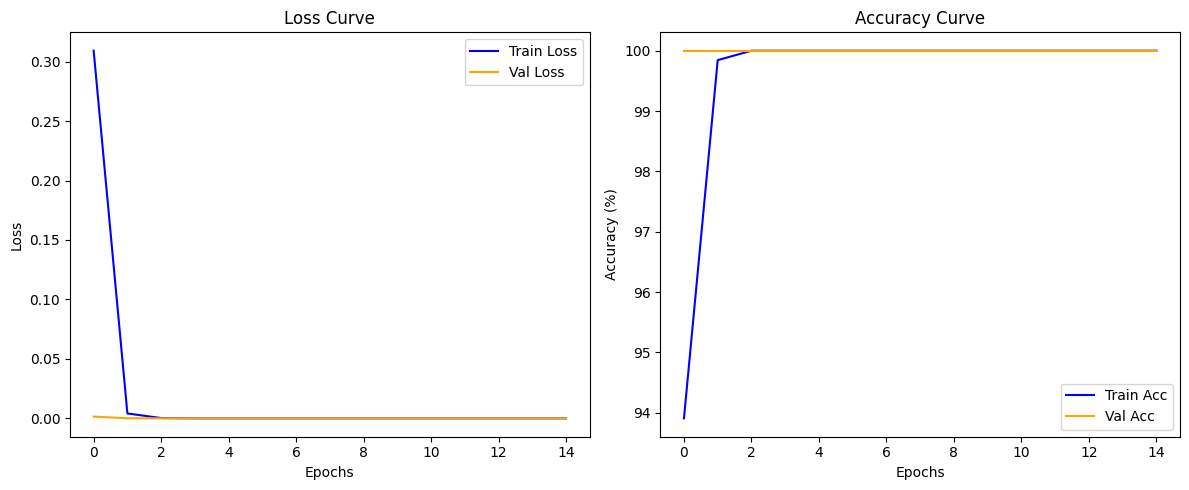

In [36]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history['train_loss'], label='Train Loss', color='blue')
plt.plot(history['val_loss'], label='Val Loss', color='orange')
plt.title('Loss Curve')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history['train_acc'], label='Train Acc', color='blue')
plt.plot(history['val_acc'], label='Val Acc', color='orange')
plt.title('Accuracy Curve')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.tight_layout()
plt.savefig('learning_curves.png')
plt.show()

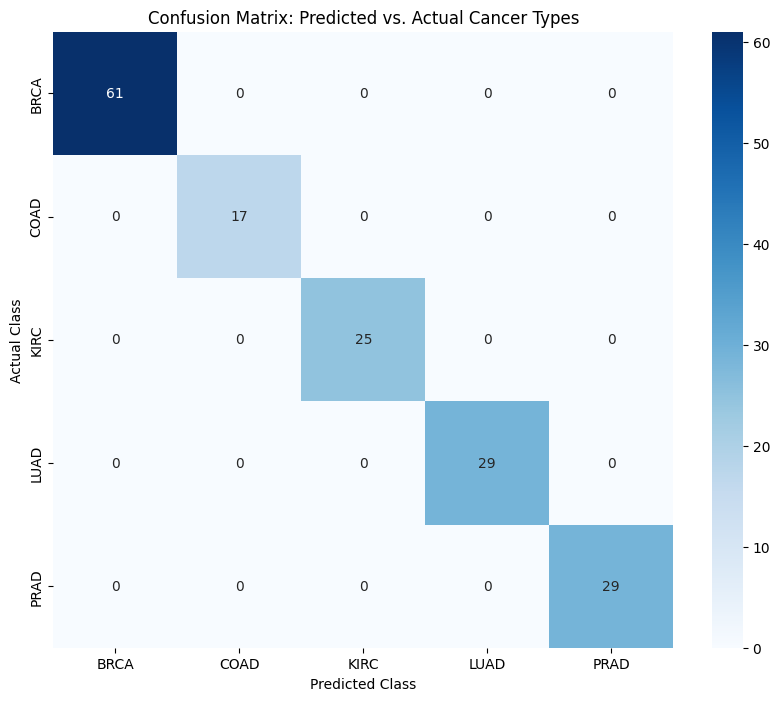

              precision    recall  f1-score   support

        BRCA       1.00      1.00      1.00        61
        COAD       1.00      1.00      1.00        17
        KIRC       1.00      1.00      1.00        25
        LUAD       1.00      1.00      1.00        29
        PRAD       1.00      1.00      1.00        29

    accuracy                           1.00       161
   macro avg       1.00      1.00      1.00       161
weighted avg       1.00      1.00      1.00       161



In [37]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

model.eval()
y_pred = []
with torch.no_grad():
    for batch_x, _ in test_loader:
        outputs, _ = model(batch_x)
        preds = torch.argmax(outputs, dim=1)
        y_pred.extend(preds.numpy())

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=le.classes_, yticklabels=le.classes_, cmap='Blues')
plt.xlabel('Predicted Class')
plt.ylabel('Actual Class')
plt.title('Confusion Matrix: Predicted vs. Actual Cancer Types')
plt.savefig('heatmap actualized')
plt.show()

print(classification_report(y_test, y_pred, target_names=le.classes_))

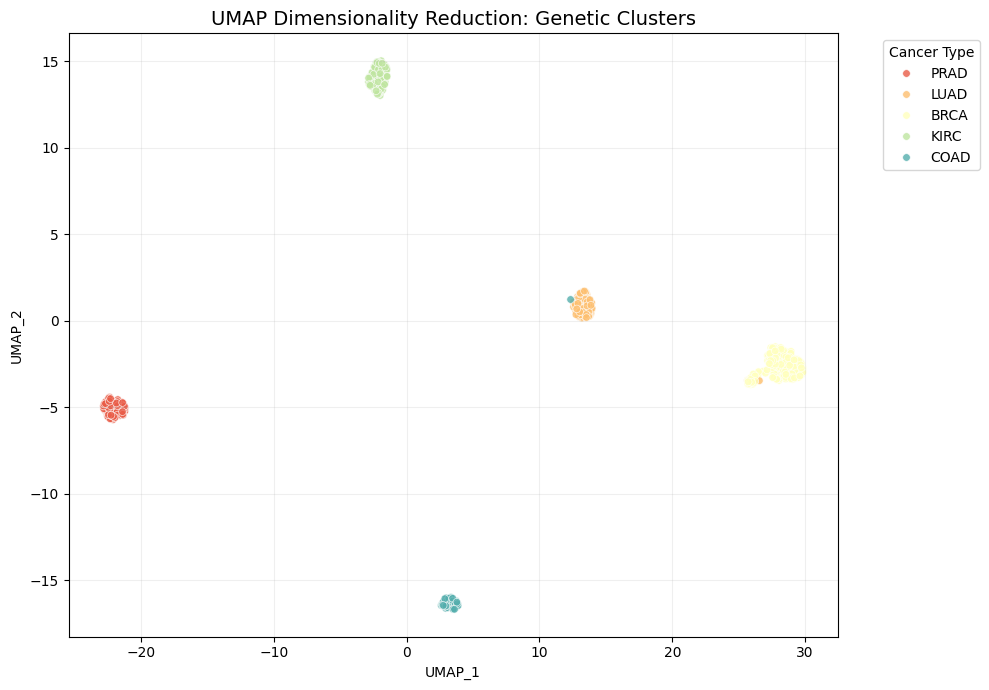

In [42]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# 1. Aplanamos 'y' para que sea una sola dimensión (vector)
# Si 'y' es un DataFrame, usamos values.ravel()
y_flat = np.array(y).ravel() 

# Convertimos a Series de Pandas limpia
y_labels = pd.Series(y_flat).reset_index(drop=True)

# 2. Creamos el DataFrame para el gráfico
# Asegúrate de que 'embedding' tenga la misma cantidad de filas que 'y_labels'
df_plot = pd.DataFrame({
    'UMAP_1': embedding[:, 0],
    'UMAP_2': embedding[:, 1],
    'Cancer_Type': y_labels
})

# 3. Graficamos
plt.figure(figsize=(10, 7))
sns.scatterplot(
    data=df_plot,
    x='UMAP_1', 
    y='UMAP_2', 
    hue='Cancer_Type',
    palette='Spectral', # O 'viridis'
    s=30,
    alpha=0.8,
    edgecolor='w',
    linewidth=0.5
)

plt.title('UMAP Dimensionality Reduction: Genetic Clusters', fontsize=14)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', title='Cancer Type')
plt.grid(True, alpha=0.2)
plt.tight_layout()
plt.savefig('UMAP')
plt.show()

In [13]:
%pip install shap

   ---------------------------------------- 0.0/549.1 kB ? eta -:--:--
   ------------------- -------------------- 262.1/549.1 kB ? eta -:--:--
   ---------------------------------------- 549.1/549.1 kB 2.5 MB/s eta 0:00:00
   ---------------------------------------- 0.0/2.8 MB ? eta -:--:--
   ---------------------------------- ----- 2.4/2.8 MB 12.0 MB/s eta 0:00:01
   ---------------------------------------- 2.8/2.8 MB 11.3 MB/s eta 0:00:00
   ---------------------------------------- 0.0/38.1 MB ? eta -:--:--
   - -------------------------------------- 1.3/38.1 MB 6.9 MB/s eta 0:00:06
   - -------------------------------------- 1.3/38.1 MB 6.9 MB/s eta 0:00:06
   - -------------------------------------- 1.6/38.1 MB 3.1 MB/s eta 0:00:12
   -- ------------------------------------- 2.4/38.1 MB 2.6 MB/s eta 0:00:14
   --- ------------------------------------ 3.4/38.1 MB 3.2 MB/s eta 0:00:11
   ------ --------------------------------- 5.8/38.1 MB 4.6 MB/s eta 0:00:08
   -------- ---------

  You can safely remove it manually.
  You can safely remove it manually.


In [43]:
import shap
import matplotlib.pyplot as plt
import numpy as np

genes_indices = X_log.var().sort_values(ascending=False).head(50).index
nombres_finales = [str(g) for g in genes_indices]

explainer = shap.Explainer(predict_func_small, X_train_small)
shap_values_result = explainer(X_test_small, max_evals=1000)

shap_values_result.feature_names = nombres_finales

plt.figure(figsize=(10, 10))
shap.plots.bar(shap_values_result[:,:,0], max_display=15, show=False)

plt.title("SHAP Feature Importance (Biomarker Discovery)", fontsize=15)
plt.ylabel('Genetic Features (Gene Indices)')
plt.xlabel('Mean SHAP Value (Average impact on model output)')
plt.tight_layout()
plt.savefig('SHAP')
plt.show()

NameError: name 'genes_columns' is not defined

In [19]:
import torch

torch.save(model.state_dict(), 'best_model_oncoclass.pth')
print("Modelo guardado exitosamente.")

Modelo guardado exitosamente.
